## Import Packages

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer


import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

import newspaper
from newspaper import Article
from newspaper.article import ArticleException

from tqdm import tqdm

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cameronbayer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## News Site Scraping

In [2]:
sites_df = {
    'link': [
        'https://www.foxnews.com/politics',
        'https://www.breitbart.com/politics/',
        'https://www.theamericanconservative.com/category/politics/',
        'https://www.oann.com/',
        'https://fortune.com/the-latest/',
        'https://www.forbes.com/?sh=4c70701d2254',
        'https://www.cbsnews.com/',
        'https://www.bbc.com/news',
        'https://www.cnn.com/politics',
        'https://www.politico.com/',
        'https://www.vox.com/',
        'https://www.msnbc.com/',
        'https://www.businessinsider.com/politics'
    ],
    'name': [
        'Fox News', 'Breitbart', 'The American Conservative', 'OANN',
        'Fortune', 'Forbes', 'CBS News', 'BBC News', 'CNN',
        'Politico', 'Vox', 'MSNBC', 'Business Insider'
    ],
    'affiliation': [
        'Right', 'Right', 'Right', 'Right', 'Center', 
        'Center', 'Center', 'Center', 'Left', 
        'Left', 'Left', 'Left', 'Left'
    ]
}

sites = pd.DataFrame(sites_df)
sites

,link,name,affiliation
0,https://www.foxnews.com/politics,Fox News,Right
1,https://www.breitbart.com/politics/,Breitbart,Right
2,https://www.theamericanconservative.com/catego...,The American Conservative,Right
3,https://www.oann.com/,OANN,Right
4,https://fortune.com/the-latest/,Fortune,Center
5,https://www.forbes.com/?sh=4c70701d2254,Forbes,Center
6,https://www.cbsnews.com/,CBS News,Center
7,https://www.bbc.com/news,BBC News,Center
8,https://www.cnn.com/politics,CNN,Left
9,https://www.politico.com/,Politico,Left


In [3]:
articles_data = []

for i, site in enumerate(tqdm(sites['link'], desc='Processing sites')):
    try:
        paper = newspaper.build(site, memoize_articles=False)
    except Exception as e:
        print(f"Failed to build newspaper for site {site}: {e}")
        continue

    for links in tqdm(paper.articles, desc=f'Processing articles from {site}', leave=False):
        article = Article(links.url)
        try:
            article.download()
            article.parse()
            articles_data.append({'title': article.title, 'authors': article.authors, 'text': article.text, 'article': links.url, 'site': site, 'site_name': sites.loc[i, 'name'], 'bias': sites.loc[i, 'affiliation']})
        except ArticleException as e:
            print(f"ArticleException for {links.url}: {e}")
            continue
        except Exception as e:
            print(f"Unexpected exception for {links.url}: {e}")
            continue


all_news_articles = pd.DataFrame(articles_data)
all_news_articles

Processing sites:   0%|          | 0/13 [00:00<?, ?it/s]

ArticleException for https://help.fox.com/s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-Roku: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-Roku (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-Roku
ArticleException for https://help.fox.com/s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-Apple-TV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-Apple-TV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issu

ArticleException for https://help.fox.com/s/article/How-do-I-watch-FOX-Nation-on-Samsung-TV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-do-I-watch-FOX-Nation-on-Samsung-TV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-do-I-watch-FOX-Nation-on-Samsung-TV
ArticleException for https://help.fox.com/s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-FireTV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-to-Sign-in-to-your-Existing-Fox-Nation-Account-on-FireTV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/

ArticleException for https://help.fox.com/s/article/How-can-I-watch-FOX-Nation-on-my-Android-TV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-can-I-watch-FOX-Nation-on-my-Android-TV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-can-I-watch-FOX-Nation-on-my-Android-TV
ArticleException for https://help.fox.com/s/article/How-do-I-watch-FOX-Nation-on-a-Vizio-Smart-TV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-do-I-watch-FOX-Nation-on-a-Vizio-Smart-TV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-do-I

ArticleException for https://help.fox.com/s/article/How-do-I-watch-FOX-Nation-on-LG-Smart-TV: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-do-I-watch-FOX-Nation-on-LG-Smart-TV (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-do-I-watch-FOX-Nation-on-LG-Smart-TV
ArticleException for https://help.fox.com/s/article/How-can-I-stream-FOX-Nation: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-can-I-stream-FOX-Nation (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-can-I-stream-FOX-Nation


ArticleException for https://help.fox.com/s/article/How-do-I-Watch-Fox-News-on-Fox-Nation: Article `download()` failed with HTTPSConnectionPool(host='help.fox.com', port=443): Max retries exceeded with url: /s/article/How-do-I-Watch-Fox-News-on-Fox-Nation (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) on URL https://help.fox.com/s/article/How-do-I-Watch-Fox-News-on-Fox-Nation


Processing sites:   0%|          | 0/13 [01:17<?, ?it/s]


KeyboardInterrupt: 

## Filtering Scraped Articles

In [ ]:
news_filtered = all_news_articles[all_news_articles['authors'].apply(lambda x: len(x) > 0)]
news_filtered

### See bias distribution

In [ ]:
sns.countplot(y=news_filtered['bias'])

In [ ]:
news_filtered['bias'].value_counts()

### Make sure there are the same number of each bias

In [ ]:
df_filtered = news_filtered.groupby('bias').head(676).reset_index(drop=True)
df_filtered

## Load Filtered News Articles (Skip to Here)

In [9]:
df_filtered = pd.read_csv("filtered_news_articles.csv")
df_filtered

,title,authors,text,article,site,site_name,bias
0,NY v Trump: Michael Cohen admits to stealing t...,['Emma Colton'],Former Trump attorney Michael Cohen admitted i...,https://www.foxnews.com/politics/ny-v-trump-mi...,https://www.foxnews.com/politics,Fox News,Right
1,Louisiana governor poised to sign stringent tr...,['Charles Creitz'],The Louisiana House and Senate became the late...,https://www.foxnews.com/politics/louisiana-pas...,https://www.foxnews.com/politics,Fox News,Right
2,Biden suggests he was vice president during CO...,['Charles Creitz'],Join Fox News for access to this content Plus ...,https://www.foxnews.com/politics/biden-suggest...,https://www.foxnews.com/politics,Fox News,Right
3,Biden slams ICC’s ‘outrageous’ request for Net...,['Greg Norman'],President Biden is condemning the Internationa...,https://www.foxnews.com/politics/biden-slams-i...,https://www.foxnews.com/politics,Fox News,Right
4,NY v. Trump: Prosecution rests case against Tr...,"['Posted Brandon Gillespie', 'Posted Anders Ha...",Who is Robert Costello?\n\nRobert Costello is ...,https://www.foxnews.com/live-news/may-20-trump...,https://www.foxnews.com/politics,Fox News,Right
...,...,...,...,...,...,...,...
2023,Don’t sneer at white rural voters — or delude ...,"['Eric Levitz', 'Edward Vega', 'Anna North', '...","White rural Americans are a “racist, xenophobi...",https://www.vox.com/politics/24128478/white-ru...,https://www.vox.com/,Vox,Left
2024,How to be enough,"['Allie Volpe', 'Apr']","Recently, psychologist Maytal Eyal has observe...",https://www.vox.com/the-highlight/24091379/how...,https://www.vox.com/,Vox,Left
2025,The Vatican’s new statement on trans rights un...,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",A new Vatican document released April 8 detail...,https://www.vox.com/24126650/vatican-dignity-t...,https://www.vox.com/,Vox,Left
2026,How solar eclipse tourism became big business,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",The biggest US travel event of this year might...,https://www.vox.com/travel/2024/4/4/24120289/s...,https://www.vox.com/,Vox,Left


### Clean Up Scraped Text

In [10]:
df_filtered['clean_text'] = df_filtered['text'].apply(lambda x: str(x).lower())
df_filtered

,title,authors,text,article,site,site_name,bias,clean_text
0,NY v Trump: Michael Cohen admits to stealing t...,['Emma Colton'],Former Trump attorney Michael Cohen admitted i...,https://www.foxnews.com/politics/ny-v-trump-mi...,https://www.foxnews.com/politics,Fox News,Right,former trump attorney michael cohen admitted i...
1,Louisiana governor poised to sign stringent tr...,['Charles Creitz'],The Louisiana House and Senate became the late...,https://www.foxnews.com/politics/louisiana-pas...,https://www.foxnews.com/politics,Fox News,Right,the louisiana house and senate became the late...
2,Biden suggests he was vice president during CO...,['Charles Creitz'],Join Fox News for access to this content Plus ...,https://www.foxnews.com/politics/biden-suggest...,https://www.foxnews.com/politics,Fox News,Right,join fox news for access to this content plus ...
3,Biden slams ICC’s ‘outrageous’ request for Net...,['Greg Norman'],President Biden is condemning the Internationa...,https://www.foxnews.com/politics/biden-slams-i...,https://www.foxnews.com/politics,Fox News,Right,president biden is condemning the internationa...
4,NY v. Trump: Prosecution rests case against Tr...,"['Posted Brandon Gillespie', 'Posted Anders Ha...",Who is Robert Costello?\n\nRobert Costello is ...,https://www.foxnews.com/live-news/may-20-trump...,https://www.foxnews.com/politics,Fox News,Right,who is robert costello?\n\nrobert costello is ...
...,...,...,...,...,...,...,...,...
2023,Don’t sneer at white rural voters — or delude ...,"['Eric Levitz', 'Edward Vega', 'Anna North', '...","White rural Americans are a “racist, xenophobi...",https://www.vox.com/politics/24128478/white-ru...,https://www.vox.com/,Vox,Left,"white rural americans are a “racist, xenophobi..."
2024,How to be enough,"['Allie Volpe', 'Apr']","Recently, psychologist Maytal Eyal has observe...",https://www.vox.com/the-highlight/24091379/how...,https://www.vox.com/,Vox,Left,"recently, psychologist maytal eyal has observe..."
2025,The Vatican’s new statement on trans rights un...,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",A new Vatican document released April 8 detail...,https://www.vox.com/24126650/vatican-dignity-t...,https://www.vox.com/,Vox,Left,a new vatican document released april 8 detail...
2026,How solar eclipse tourism became big business,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",The biggest US travel event of this year might...,https://www.vox.com/travel/2024/4/4/24120289/s...,https://www.vox.com/,Vox,Left,the biggest us travel event of this year might...


In [11]:
for i, row in enumerate(df_filtered['clean_text']):
    df_filtered.loc[i, 'clean_text'] = ' '.join([word for word in row.split() if word not in en_stopwords])
df_filtered

,title,authors,text,article,site,site_name,bias,clean_text
0,NY v Trump: Michael Cohen admits to stealing t...,['Emma Colton'],Former Trump attorney Michael Cohen admitted i...,https://www.foxnews.com/politics/ny-v-trump-mi...,https://www.foxnews.com/politics,Fox News,Right,former trump attorney michael cohen admitted t...
1,Louisiana governor poised to sign stringent tr...,['Charles Creitz'],The Louisiana House and Senate became the late...,https://www.foxnews.com/politics/louisiana-pas...,https://www.foxnews.com/politics,Fox News,Right,louisiana house senate became latest state leg...
2,Biden suggests he was vice president during CO...,['Charles Creitz'],Join Fox News for access to this content Plus ...,https://www.foxnews.com/politics/biden-suggest...,https://www.foxnews.com/politics,Fox News,Right,join fox news access content plus special acce...
3,Biden slams ICC’s ‘outrageous’ request for Net...,['Greg Norman'],President Biden is condemning the Internationa...,https://www.foxnews.com/politics/biden-slams-i...,https://www.foxnews.com/politics,Fox News,Right,president biden condemning international crimi...
4,NY v. Trump: Prosecution rests case against Tr...,"['Posted Brandon Gillespie', 'Posted Anders Ha...",Who is Robert Costello?\n\nRobert Costello is ...,https://www.foxnews.com/live-news/may-20-trump...,https://www.foxnews.com/politics,Fox News,Right,robert costello? robert costello former legal ...
...,...,...,...,...,...,...,...,...
2023,Don’t sneer at white rural voters — or delude ...,"['Eric Levitz', 'Edward Vega', 'Anna North', '...","White rural Americans are a “racist, xenophobi...",https://www.vox.com/politics/24128478/white-ru...,https://www.vox.com/,Vox,Left,"white rural americans “racist, xenophobic, ant..."
2024,How to be enough,"['Allie Volpe', 'Apr']","Recently, psychologist Maytal Eyal has observe...",https://www.vox.com/the-highlight/24091379/how...,https://www.vox.com/,Vox,Left,"recently, psychologist maytal eyal observed ca..."
2025,The Vatican’s new statement on trans rights un...,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",A new Vatican document released April 8 detail...,https://www.vox.com/24126650/vatican-dignity-t...,https://www.vox.com/,Vox,Left,new vatican document released april 8 details ...
2026,How solar eclipse tourism became big business,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",The biggest US travel event of this year might...,https://www.vox.com/travel/2024/4/4/24120289/s...,https://www.vox.com/,Vox,Left,biggest us travel event year might taylor swif...


In [12]:
df_filtered['clean_text'] = df_filtered['clean_text'].str.strip()

df_filtered['clean_text'] = df_filtered['clean_text'].str.strip().str.replace(r'[^\w\s]', '', regex=True)

df_filtered

,title,authors,text,article,site,site_name,bias,clean_text
0,NY v Trump: Michael Cohen admits to stealing t...,['Emma Colton'],Former Trump attorney Michael Cohen admitted i...,https://www.foxnews.com/politics/ny-v-trump-mi...,https://www.foxnews.com/politics,Fox News,Right,former trump attorney michael cohen admitted t...
1,Louisiana governor poised to sign stringent tr...,['Charles Creitz'],The Louisiana House and Senate became the late...,https://www.foxnews.com/politics/louisiana-pas...,https://www.foxnews.com/politics,Fox News,Right,louisiana house senate became latest state leg...
2,Biden suggests he was vice president during CO...,['Charles Creitz'],Join Fox News for access to this content Plus ...,https://www.foxnews.com/politics/biden-suggest...,https://www.foxnews.com/politics,Fox News,Right,join fox news access content plus special acce...
3,Biden slams ICC’s ‘outrageous’ request for Net...,['Greg Norman'],President Biden is condemning the Internationa...,https://www.foxnews.com/politics/biden-slams-i...,https://www.foxnews.com/politics,Fox News,Right,president biden condemning international crimi...
4,NY v. Trump: Prosecution rests case against Tr...,"['Posted Brandon Gillespie', 'Posted Anders Ha...",Who is Robert Costello?\n\nRobert Costello is ...,https://www.foxnews.com/live-news/may-20-trump...,https://www.foxnews.com/politics,Fox News,Right,robert costello robert costello former legal a...
...,...,...,...,...,...,...,...,...
2023,Don’t sneer at white rural voters — or delude ...,"['Eric Levitz', 'Edward Vega', 'Anna North', '...","White rural Americans are a “racist, xenophobi...",https://www.vox.com/politics/24128478/white-ru...,https://www.vox.com/,Vox,Left,white rural americans racist xenophobic antiim...
2024,How to be enough,"['Allie Volpe', 'Apr']","Recently, psychologist Maytal Eyal has observe...",https://www.vox.com/the-highlight/24091379/how...,https://www.vox.com/,Vox,Left,recently psychologist maytal eyal observed cal...
2025,The Vatican’s new statement on trans rights un...,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",A new Vatican document released April 8 detail...,https://www.vox.com/24126650/vatican-dignity-t...,https://www.vox.com/,Vox,Left,new vatican document released april 8 details ...
2026,How solar eclipse tourism became big business,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",The biggest US travel event of this year might...,https://www.vox.com/travel/2024/4/4/24120289/s...,https://www.vox.com/,Vox,Left,biggest us travel event year might taylor swif...


## Transformations

In [13]:
test_df = df_filtered.copy()

label_encoder = LabelEncoder()
test_df['bias'] = label_encoder.fit_transform(test_df['bias'])
test_df

,title,authors,text,article,site,site_name,bias,clean_text
0,NY v Trump: Michael Cohen admits to stealing t...,['Emma Colton'],Former Trump attorney Michael Cohen admitted i...,https://www.foxnews.com/politics/ny-v-trump-mi...,https://www.foxnews.com/politics,Fox News,2,former trump attorney michael cohen admitted t...
1,Louisiana governor poised to sign stringent tr...,['Charles Creitz'],The Louisiana House and Senate became the late...,https://www.foxnews.com/politics/louisiana-pas...,https://www.foxnews.com/politics,Fox News,2,louisiana house senate became latest state leg...
2,Biden suggests he was vice president during CO...,['Charles Creitz'],Join Fox News for access to this content Plus ...,https://www.foxnews.com/politics/biden-suggest...,https://www.foxnews.com/politics,Fox News,2,join fox news access content plus special acce...
3,Biden slams ICC’s ‘outrageous’ request for Net...,['Greg Norman'],President Biden is condemning the Internationa...,https://www.foxnews.com/politics/biden-slams-i...,https://www.foxnews.com/politics,Fox News,2,president biden condemning international crimi...
4,NY v. Trump: Prosecution rests case against Tr...,"['Posted Brandon Gillespie', 'Posted Anders Ha...",Who is Robert Costello?\n\nRobert Costello is ...,https://www.foxnews.com/live-news/may-20-trump...,https://www.foxnews.com/politics,Fox News,2,robert costello robert costello former legal a...
...,...,...,...,...,...,...,...,...
2023,Don’t sneer at white rural voters — or delude ...,"['Eric Levitz', 'Edward Vega', 'Anna North', '...","White rural Americans are a “racist, xenophobi...",https://www.vox.com/politics/24128478/white-ru...,https://www.vox.com/,Vox,1,white rural americans racist xenophobic antiim...
2024,How to be enough,"['Allie Volpe', 'Apr']","Recently, psychologist Maytal Eyal has observe...",https://www.vox.com/the-highlight/24091379/how...,https://www.vox.com/,Vox,1,recently psychologist maytal eyal observed cal...
2025,The Vatican’s new statement on trans rights un...,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",A new Vatican document released April 8 detail...,https://www.vox.com/24126650/vatican-dignity-t...,https://www.vox.com/,Vox,1,new vatican document released april 8 details ...
2026,How solar eclipse tourism became big business,"['Li Zhou', 'Edward Vega', 'Anna North', 'Josh...",The biggest US travel event of this year might...,https://www.vox.com/travel/2024/4/4/24120289/s...,https://www.vox.com/,Vox,1,biggest us travel event year might taylor swif...


### Split the Data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(test_df['clean_text'], test_df['bias'], test_size=0.2, stratify=test_df['bias'], random_state=42)
X_test

309     new hampshire state senate sided common sense ...
1590    cnn  offduty police officer shot injured monda...
398     join fox news access content plus special acce...
1436    oleksandr usyk golpea tyson fury durante la pe...
1404    verificación de datos del tercer debate presid...
                              ...                        
916     insulin prices capped millions qualify insulin...
1238    inside struggle middletier retailers middletie...
989     biden speaks naacp event detroit propane tank ...
390     staff reporters new york times bashed boss exe...
1985    youre millennial may remember specific moment ...
Name: clean_text, Length: 406, dtype: object

### Vectorize Text (TF-IDF)

In [15]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Logistic Regression

In [16]:
# Model training
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Model evaluation
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.8940886699507389
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       135
           1       0.86      0.90      0.88       135
           2       0.95      0.90      0.93       136

    accuracy                           0.89       406
   macro avg       0.90      0.89      0.89       406
weighted avg       0.90      0.89      0.89       406



### Support Vector Machine (SVM)

In [17]:
model = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9014778325123153
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       135
           1       0.90      0.89      0.89       135
           2       0.95      0.90      0.93       136

    accuracy                           0.90       406
   macro avg       0.90      0.90      0.90       406
weighted avg       0.90      0.90      0.90       406



### Random Forest

In [18]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9310344827586207
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       135
           1       0.89      0.97      0.93       135
           2       0.98      0.91      0.94       136

    accuracy                           0.93       406
   macro avg       0.93      0.93      0.93       406
weighted avg       0.93      0.93      0.93       406



### Gradient Boosting

In [19]:
model = GradientBoostingClassifier()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9384236453201971
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       135
           1       0.95      0.94      0.95       135
           2       0.95      0.90      0.92       136

    accuracy                           0.94       406
   macro avg       0.94      0.94      0.94       406
weighted avg       0.94      0.94      0.94       406



### XGBoost (Best)

In [20]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9408866995073891
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       135
           1       0.95      0.96      0.95       135
           2       0.93      0.93      0.93       136

    accuracy                           0.94       406
   macro avg       0.94      0.94      0.94       406
weighted avg       0.94      0.94      0.94       406



## Testing

In [21]:
news_article = 'https://www.cnn.com/2024/05/21/politics/ai-2024-election-interference-dhs-warns/index.html'

first_article = Article(url=news_article)
first_article.download()
first_article.parse()
print(first_article.text)

CNN —

Artificial intelligence tools for creating fake video, audio and other content will likely give foreign operatives and domestic extremists “enhanced opportunities for interference” as the 2024 US election cycle progresses, the Department of Homeland Security said in a recent bulletin distributed to state and local officials and obtained by CNN.

A variety of “threat actors” will likely try to use generative AI — or AI that creates fake content — to influence or “sow discord” during the US election cycle, says the May 17 bulletin, which was produced by the DHS Office of Intelligence and Analysis.

While a “large-scale attack on the election is less likely” because of the “higher risk of detection and the decentralized and diverse nature of the voting system,” the bulletin says, “threat actors might still attempt to conduct limited operations leading to disruptions in key election battleground areas.”

Foreign or domestic operatives could, for example, try to “confuse or overwhelm

In [23]:
def predict_party(text):
    text_tfidf = tfidf.transform([text])
    prediction = model.predict(text_tfidf)
    # Uncomment below for probability distribution for XGBoost
    y_pred_proba = model.predict_proba(text_tfidf)
    print(y_pred_proba)
    return "Left" if prediction[0] == 1 else "Right" if prediction[0] == 2 else "Center"

new_article = first_article.text
predicted_party = predict_party(new_article)
print(f'The predicted party affiliation is: {predicted_party}')

[[0.02196019 0.03531748 0.9427223 ]]
The predicted party affiliation is: Right


# Experimental

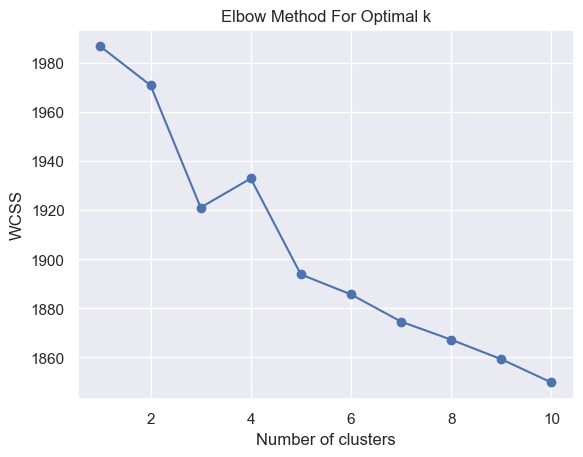

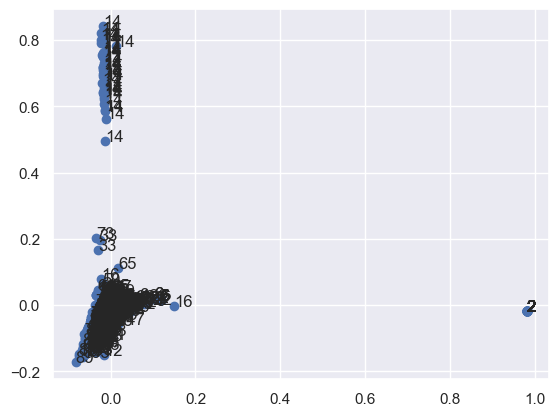

In [47]:
# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(test_df['clean_text'])

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()


# Perform K-means clustering
num_clusters = round(len(test_df['clean_text'])/10)
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)

labels = kmeans.labels_

combined_data = {
    'clean_text': test_df['clean_text'],
    'bias': test_df['bias'],
    'cluster_label': labels,
    'article': test_df['article']
}
result_df = pd.DataFrame(combined_data)


from sklearn.decomposition import PCA

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X.toarray())

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots()
ax.scatter(x_axis, y_axis)

for i, txt in enumerate(labels):
    ax.annotate(txt, (x_axis[i], y_axis[i]))

plt.show()


In [59]:
result_df[result_df['cluster_label'] == 16].groupby('bias').head(5)

,clean_text,bias,cluster_label,article
66,join fox news access content plus special acce...,2,16,https://www.foxnews.com/us/most-ruthless-mexic...
70,join fox news access content plus special acce...,2,16,https://www.foxnews.com/lifestyle/meet-america...
158,story 1 michael cohen convicted liar hes admit...,2,16,https://radio.foxnews.com/2024/05/20/aoc-and-m...
177,today guy benson show welcomed gat israeli man...,2,16,https://radio.foxnews.com/2024/05/16/oct-7-sto...
180,congressman tony gonzales rtx spoke brian kilm...,2,16,https://radio.foxnews.com/2024/05/16/rep-tony-...
703,one woman hoping open first black woman ownedb...,0,16,https://www.cbsnews.com/minnesota/news/a-black...
705,shakopee minn according american heart associ...,0,16,https://www.cbsnews.com/minnesota/news/good-sa...
731,concert season colorado back full swing fiddle...,0,16,https://www.cbsnews.com/colorado/news/fiddlers...
766,516 cbs morning news 516 cbs morning news 2034...,0,16,https://www.cbsnews.com/colorado/news/electrol...
797,may receive commissions links products page pr...,0,16,https://www.cbsnews.com/news/is-a-10000-deposi...


In [62]:
result_df['article'][66]

'https://www.foxnews.com/us/most-ruthless-mexican-cartels-operate-all-50-states-brings-turf-wars-us-dea'

In [61]:
result_df['article'][1567]

'https://us.cnn.com/2024/05/18/entertainment/david-copperfield-sex-assault-allegations-guardian/index.html'